In [112]:
import torch
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from copy import deepcopy
import matplotlib.pyplot as plt
import torch.nn as nn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import os
import sys
import matplotlib.pyplot as plt

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

from env import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

from custom_observation import CustomObservationFunction
from custom_reward import reward_fn

In [113]:
class DQNetwork(nn.Module):
    def __init__(self, inp_size, op_size):
        super(DQNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.hl1 = nn.Linear(inp_size, 128)
        self.hl2 = nn.Linear(128, 128)
        self.fc = nn.Linear(128, op_size)
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_normal_(self.hl1.weight)
        torch.nn.init.xavier_normal_(self.hl2.weight)
        torch.nn.init.xavier_normal_(self.fc.weight)
        torch.nn.init.zeros_(self.hl1.bias)
        torch.nn.init.zeros_(self.hl2.bias)
        torch.nn.init.zeros_(self.fc.bias)
    
    def forward(self, x):
        x = self.hl1(x)
        x = self.activation(x)
        x = self.hl2(x)
        x = self.activation(x)
        x = self.fc(x)
        return x

In [114]:
class GreedyAgent:
    
    def __init__(self, model, env, initial_epsilon, epsilon_decay, final_epsilon, discount_factor, num_episodes=1000):
        self.env = env
        self.model = model
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
    def step(self, obs, train=True):
        if train:
            if np.random.random() < self.epsilon:
                return self.action_space.sample()
            else:
                self.model.eval()
                with torch.no_grad():
                    output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                    return torch.argmax(output).item()
        else:
            self.model.eval()
            with torch.no_grad():
                output = self.model(torch.from_numpy(obs['t']).to(dtype=torch.float32))
                return torch.argmax(output).item()
        

    def decay(self):
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)

In [121]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=False,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomObservationFunction,
        reward_fn = reward_fn
    )

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [122]:
# training params
BUFFER_SIZE = 500
batch_size = 32
sync_target_step = 4
train_every_step = 3
episodes = 10
replay_buffer = torch.zeros((BUFFER_SIZE, 5 + 1 + 1 + 5 + 1), dtype = torch.float32) #[sx4, a, r, s'x4, terminate flag]
learning_rate = 0.001

#agent params
start_epsilon = 0.9
final_epsilon = 0.01
epsilon_decay = (final_epsilon/start_epsilon)**(1/episodes)  # exponential decay
discount_factor = 0.99

# model init
model = DQNetwork(env.observation_space.shape[0], env.action_space.n)
target_model = deepcopy(model)

agent = GreedyAgent(model, env, start_epsilon, epsilon_decay, final_epsilon, discount_factor)

# optimizer and criterion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [123]:
n_iters = 0 
train_loss = []
reward_per_episode = [0] * episodes
epsilon_per_episode = [0] * episodes
steps_per_episode = [0] * episodes
for episode in range(episodes):
    obs = env.reset()
    done = {"__all__": False}
    epsilon_per_episode[episode] = agent.epsilon
    batch_loss = []
    t = 0
    while not done["__all__"]:
        action = agent.step(obs)
        next_obs, reward, done, _ = env.step({'t': action})
        n_iters = n_iters + 1
        
        reward_per_episode[episode] += reward['t']
        replay_buffer[n_iters % BUFFER_SIZE] = torch.cat([torch.from_numpy(obs['t']), torch.tensor([action], dtype=torch.int32), torch.tensor([reward['t']], dtype=torch.int32), torch.from_numpy(next_obs['t']), torch.tensor([int(done["__all__"])], dtype=torch.int32)]).to(torch.float32)
        
        obs = deepcopy(next_obs)
        t += 1
    
    steps_per_episode[episode] += t
    agent.decay()
    env.close()
    
    if n_iters >= batch_size and episode % train_every_step == 0:

        selected_transition_indices = torch.randint(low=0, high=min(n_iters, BUFFER_SIZE), size=(batch_size, ))
        selected_transition = replay_buffer[selected_transition_indices]  #selected_transition: [sx5, a, r, s'x5]

        td_target = torch.zeros(batch_size)
        next_obs = selected_transition[:, 7:-1]
        target_model.eval()
        with torch.no_grad():
            target_output = target_model(next_obs)
            q_values, _ = torch.max(target_output, dim = 1)
            td_target = torch.where(selected_transition[:, -1] == True, selected_transition[:, 6], selected_transition[:, 6] + discount_factor * q_values)

        model.train()
        obs = selected_transition[:, :5]
        output = model(obs)
        td_estimate = output.gather(1, selected_transition[:, 5][:, None].type(torch.int64)).squeeze(1)
        loss = criterion(td_target, td_estimate)

        train_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if(episode % sync_target_step == 0):
        target_model.load_state_dict(model.state_dict())

 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 27ms, vehicles TOT 3194 ACT 40 BUF 268)             tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 2878 ACT 42 BUF 254)             
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 3531 ACT 21 BUF 0)               tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 3194 ACT 19 BUF 0)               
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 3508 ACT 51 BUF 0)               tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 3146 ACT 29 BUF 0)               
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 34ms, vehicles TOT 3154 ACT 50 BUF 372)             tep #4500.00 (1ms ~= 1000.00*RT, ~50000.00UPS, TraCI: 34ms, vehicles TOT 2818 ACT 50 BUF 
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 27ms, vehicles TOT 3470 ACT 25 BUF 0)               tep #4500.00 (1ms ~= 1000.00*RT, ~41000.00UPS, TraCI: 31ms, vehicles TOT 31

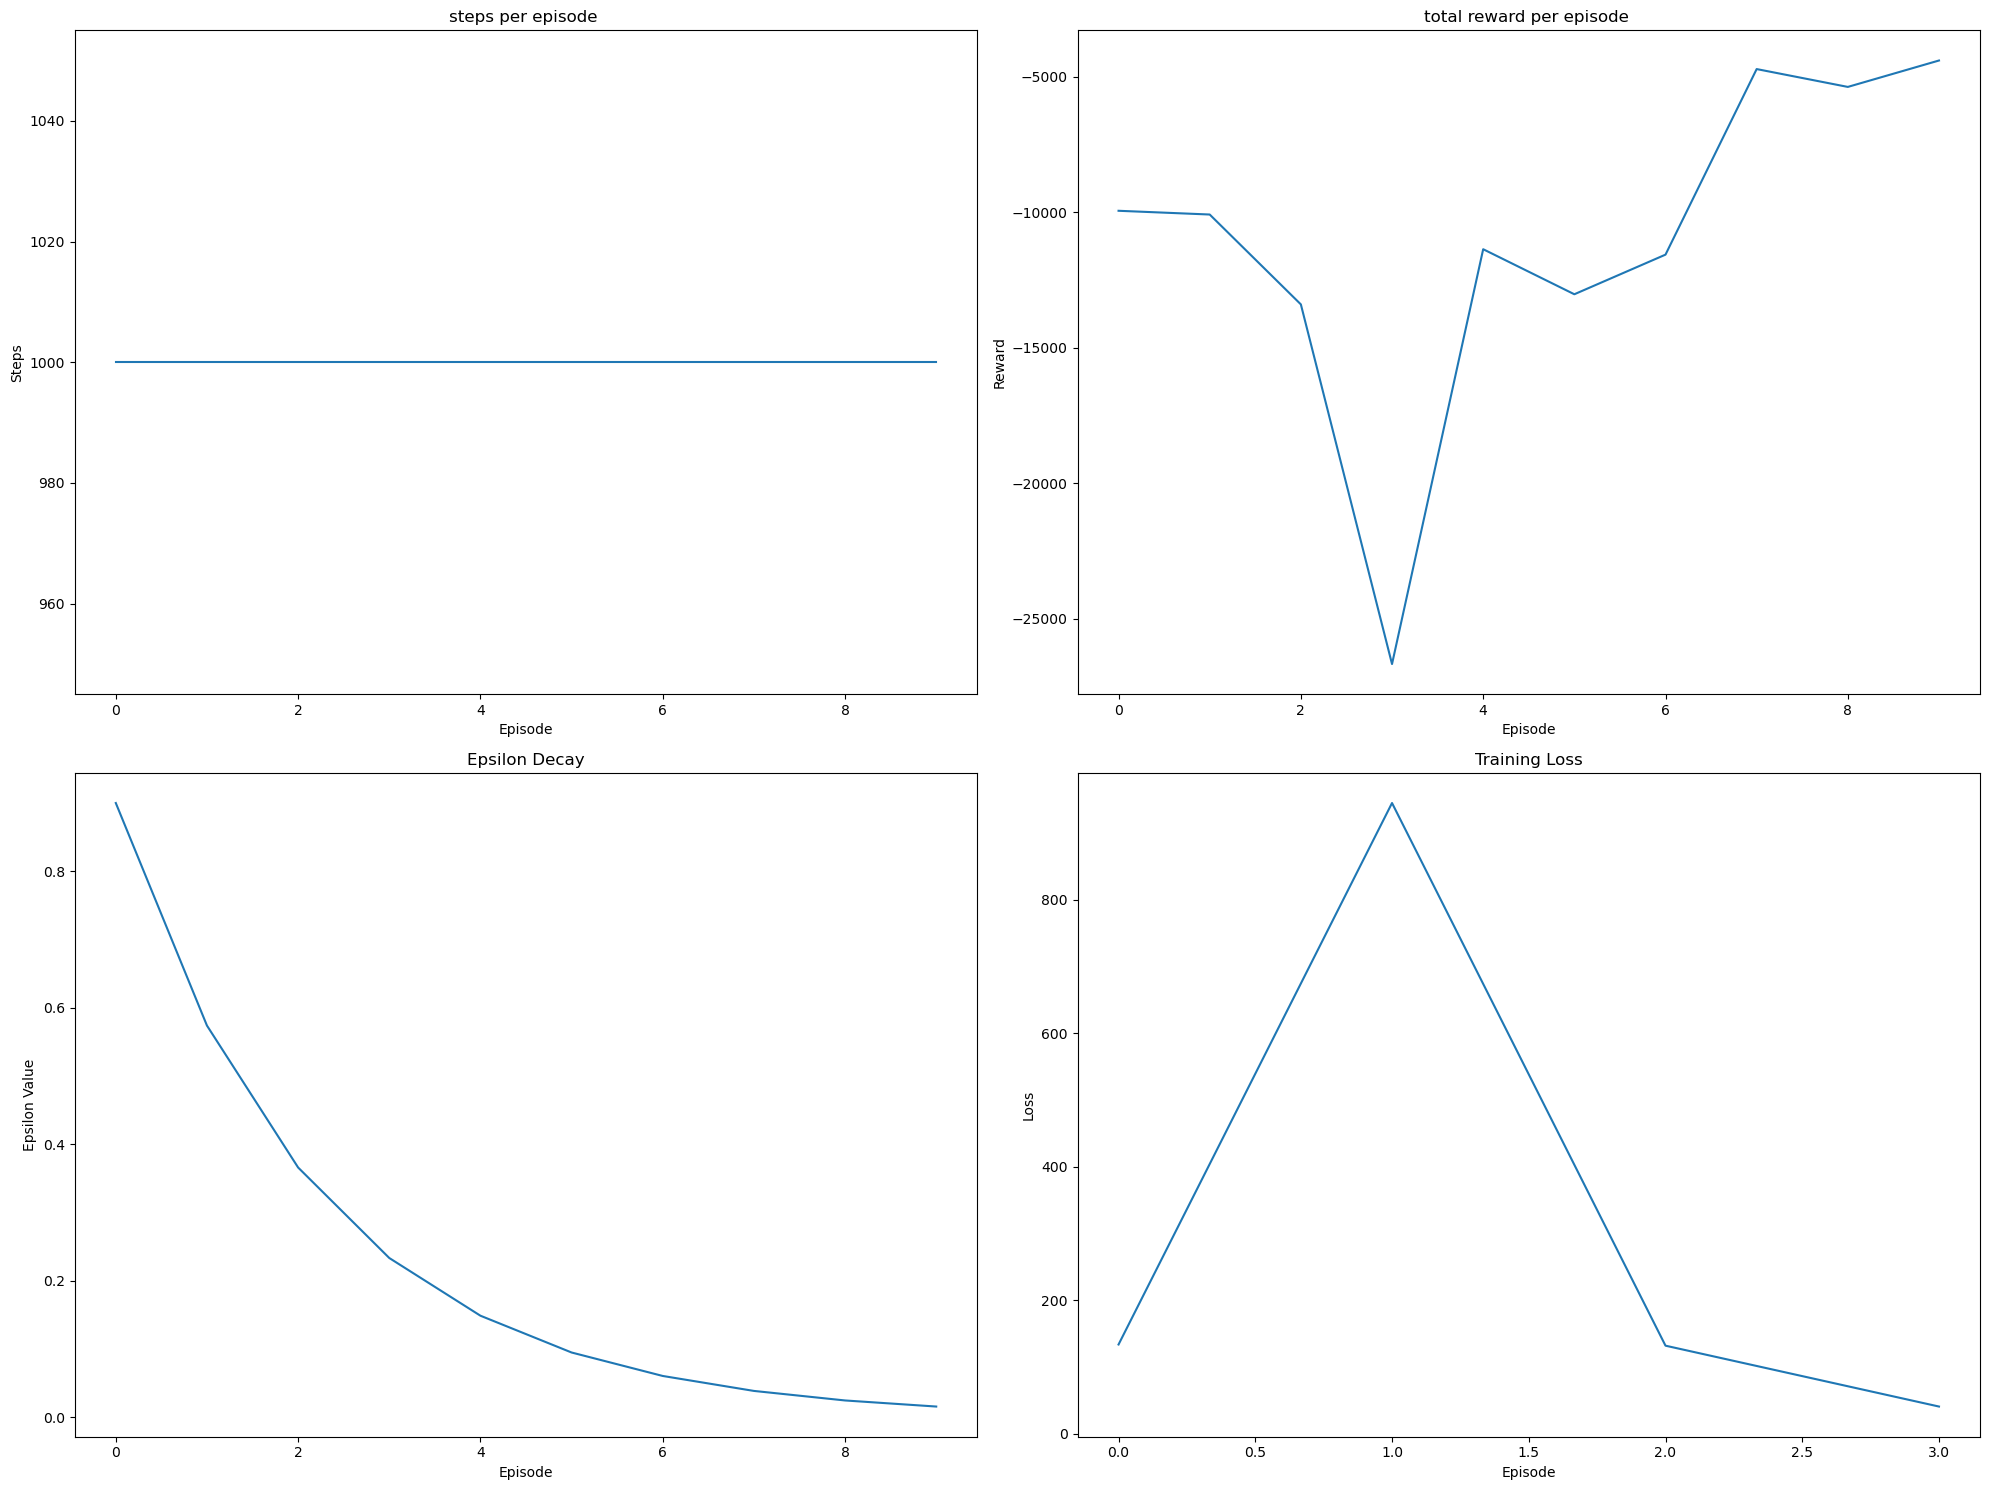

In [124]:
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

axs[0, 0].plot(range(episodes), steps_per_episode)
axs[0, 0].set_title("steps per episode ")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Steps")

axs[0, 1].plot(range(episodes), reward_per_episode)
axs[0, 1].set_title("total reward per episode ")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(range(episodes), epsilon_per_episode)
axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].set_xlabel("Episode")
axs[1, 0].set_ylabel("Epsilon Value")

axs[1, 1].plot(range(len(train_loss)), train_loss)
axs[1, 1].set_title("Training Loss")
axs[1, 1].set_xlabel("Episode")
axs[1, 1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [125]:
n_episodes = 5
agent.epsilon = 0
reward_per_episode = [0]*n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, _ = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 19ms, vehicles TOT 3450 ACT 22 BUF 0)               tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 3096 ACT 24 BUF 0)               
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 3470 ACT 18 BUF 0)               tep #4500.00 (1ms ~= 1000.00*RT, ~31000.00UPS, TraCI: 32ms, vehicles TOT 3124 ACT 31 BUF 
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~25000.00UPS, TraCI: 23ms, vehicles TOT 3590 ACT 25 BUF tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 22ms, vehicles TOT 3225 ACT 18 BUF 0)               
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 18ms, vehicles TOT 3397 ACT 19 BUF 0)               tep #4500.00 (0ms ?*RT. ?UPS, TraCI: 32ms, vehicles TOT 3068 ACT 33 BUF 0)               
 Retrying in 1 seconds
Step #4400.00 (0ms ?*RT. ?UPS, TraCI: 17ms, vehicles TOT 3098 ACT 18 BUF 0)               

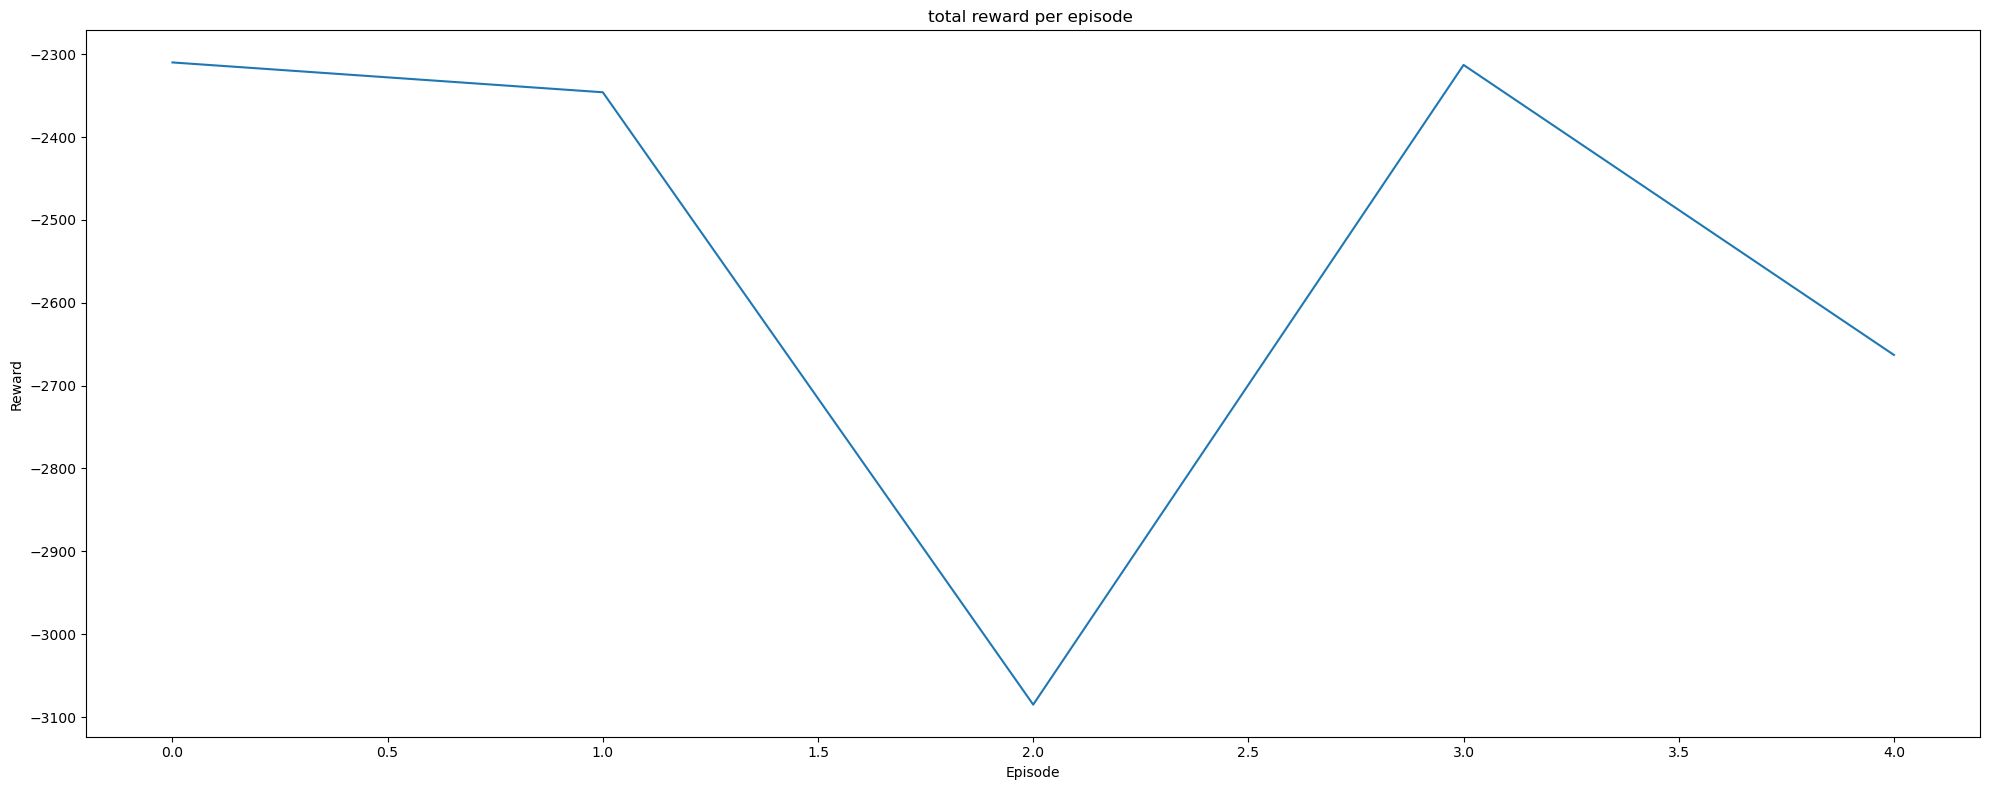

In [126]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 1, figsize=(20, 8))

axs.plot(range(n_episodes), reward_per_episode)
axs.set_title("total reward per episode ")
axs.set_xlabel("Episode")
axs.set_ylabel("Reward")

plt.tight_layout()
plt.show()

In [127]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomObservationFunction,
        reward_fn = reward_fn
    )

n_episodes = 1
agent.epsilon = 0
reward_per_episode = [0]*n_episodes

for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}

    # play one episode
    while not done["__all__"]:
        action = agent.step(obs, train=False)
        next_obs, reward, done, _ = env.step({'t': action})
        reward_per_episode[episode] += reward['t']
        obs = deepcopy(next_obs)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


In [128]:
env = SumoEnvironment(
        net_file="single-intersection/single-intersection.net.xml",
        route_file="single-intersection/single-intersection.rou.xml",
        out_csv_name="out_csv",
        use_gui=True,
        num_seconds=5000,
        min_green=5,
        max_green=10,
        observation_class = CustomObservationFunction,
        reward_fn = reward_fn
    )

n_episodes = 1
for episode in range(n_episodes):
    obs = env.reset()
    done = {"__all__": False}
    while not done["__all__"]:
        next_obs, reward, done, _ = env.step({})

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
